## This program attempts to read and understand Amazon product reviews (for a large variety of products) and determine if a review is positive or negative. The model learns a high-dimensional word embedding in order to analyze the sentiment of the review.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
from pathlib import Path
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
import pandas as pd

path = Path.cwd()
filepath = str(path)+r'\OneDrive\Desktop\Datasets\amazon_reviews.tar.gz'
my_tar = tarfile.open(filepath,
                      mode='r')
tarfiles = my_tar.getmembers()

positive_tarfiles = []
negative_tarfiles = []

for tarfile in tarfiles:
    if 'positive' in str(tarfile):
        positive_tarfiles.append(tarfile)
    if 'negative' in str(tarfile):
        negative_tarfiles.append(tarfile)

In [2]:
def extract_to_list(tarfile_list):
    review_list = []
    for tarfile in tarfile_list:
        extracted = my_tar.extractfile(tarfile).readlines()
        for i in range(len(extracted)):
            if '<review_text>' in str(extracted[i]):
                review = str(extracted[i+1])[2:-3]
                if len(review) >= 15 and len(review.split()) > 1:
                    review_list.append(review)
    return np.array(review_list)

positive_reviews = extract_to_list(positive_tarfiles)
negative_reviews = extract_to_list(negative_tarfiles)

all_reviews = np.hstack([positive_reviews,
                         negative_reviews])
all_sentiments = np.hstack([np.ones(len(positive_reviews)),
                           np.zeros(len(negative_reviews))])
print('There are {} positive reviews and {} negative reviews, for a total of {} reviews.'.format(len(positive_reviews),
                                                                                                len(negative_reviews),
                                                                                                len(all_reviews)))

There are 21765 positive reviews and 16442 negative reviews, for a total of 38207 reviews.


In [3]:
maxlen = 200
num_words = 35000
tokenizer = Tokenizer(num_words=num_words)

tokenizer.fit_on_texts(all_reviews)

def process_texts(texts,tokenizer=tokenizer):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences,
                                    maxlen=maxlen,
                                    padding='post',
                                    truncating='post')
    return padded_sequences

padded_reviews = process_texts(all_reviews)

train_sequences,test_sequences,train_labels,test_labels = train_test_split(padded_reviews,
                                                                          all_sentiments,
                                                                          test_size=.05)
word_index = tokenizer.word_index

batch_size = 32
shuffle_size = 1500

def make_dataset(x,y,batch_size=batch_size,shuffle_size=shuffle_size):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.batch(batch_size).shuffle(shuffle_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = make_dataset(train_sequences,train_labels)
validation_dataset = make_dataset(test_sequences,test_labels)

In [4]:
embedding_dim = 80
input_length = maxlen
dropout_rate = .5

l2 = keras.regularizers.L2(.5)
initializer = keras.initializers.RandomUniform(minval=1,
                                               maxval=2)

model = keras.Sequential([
    keras.layers.Embedding(input_dim=num_words,
                          output_dim=embedding_dim,
                          input_length=input_length,
                          mask_zero=True),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(100,
                     return_sequences=True,
                     kernel_regularizer=l2,
                     recurrent_dropout=dropout_rate,
                     kernel_initializer=initializer,
                     dropout=dropout_rate),
    keras.layers.BatchNormalization(),
    keras.layers.GRU(100,
                     kernel_regularizer=l2,
                     dropout=dropout_rate),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(dropout_rate),
    keras.layers.Dense(1,
                      activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 80)           2800000   
                                                                 
 batch_normalization (BatchN  (None, 200, 80)          320       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 200, 100)          72400     
                                                                 
 batch_normalization_1 (Batc  (None, 200, 100)         400       
 hNormalization)                                                 
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [5]:
epochs = 12

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                             factor=.1,
                                             patience=2,
                                             min_lr=1e-5,
                                             min_delta=.009,
                                             verbose=1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                          verbose=1,
                                          patience=3,
                                          restore_best_weights=True)

history = model.fit(train_dataset,
                   validation_data=validation_dataset,
                   epochs=epochs,
                   callbacks=[reduce_lr,
                             early_stop])

hist = history.history

Epoch 1/12
1135/1135 [==============================] - 724s 630ms/step - loss: 18502.6172 - accuracy: 0.5484 - val_loss: 6455.6743 - val_accuracy: 0.5651 - lr: 0.0010
Epoch 2/12
1135/1135 [==============================] - 697s 614ms/step - loss: 2514.0964 - accuracy: 0.6605 - val_loss: 497.1516 - val_accuracy: 0.6897 - lr: 0.0010
Epoch 3/12
1135/1135 [==============================] - 788s 694ms/step - loss: 138.6225 - accuracy: 0.7588 - val_loss: 9.4455 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 4/12
1135/1135 [==============================] - 812s 716ms/step - loss: 1.9953 - accuracy: 0.8390 - val_loss: 0.4402 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 5/12
1135/1135 [==============================] - 831s 732ms/step - loss: 0.3613 - accuracy: 0.8760 - val_loss: 0.4358 - val_accuracy: 0.8341 - lr: 0.0010
Epoch 6/12
1135/1135 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8976
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
11

#### Now that the model is done training, let's see how well it did in terms of loss, accuracy and several other metrics on the training and validation data:

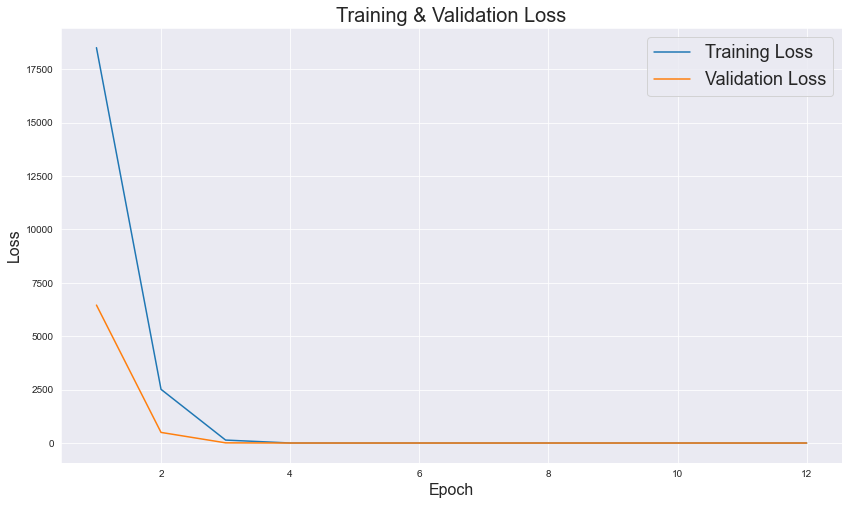

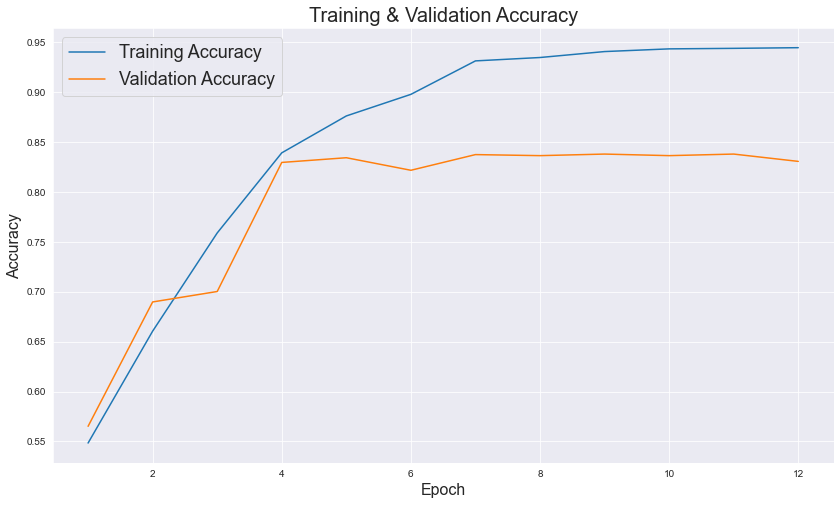

Final metrics:


,Training Metrics,Validation Metrics
Accuracy,95.4%,83.8%
Precision,95.2%,84.8%
Recall,96.9%,87.3%
F1 Score,96.0%,86.0%


In [6]:
loss = hist['loss']
val_loss = hist['val_loss']
accuracy = hist['accuracy']
val_accuracy = hist['val_accuracy']
epoch = np.arange(len(loss))+1

sns.set_style('darkgrid')
plt.figure(figsize=(14,8))
plt.plot(epoch,loss)
plt.plot(epoch,val_loss)
plt.title('Training & Validation Loss',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':16})
plt.ylabel('Loss',fontdict={'fontsize':16})
plt.legend(['Training Loss','Validation Loss'],prop={'size':18})
plt.show()

plt.figure(figsize=(14,8))
plt.plot(epoch,accuracy)
plt.plot(epoch,val_accuracy)
plt.title('Training & Validation Accuracy',fontdict={'fontsize':20})
plt.xlabel('Epoch',fontdict={'fontsize':16})
plt.ylabel('Accuracy',fontdict={'fontsize':16})
plt.legend(['Training Accuracy','Validation Accuracy'],prop={'size':18})
plt.show()

def get_metrics(sequences,labels):
    predictions = model.predict(sequences).round().squeeze()
    accuracy = '{}%'.format(round(accuracy_score(labels,predictions)*100,1))
    precision = '{}%'.format(round(precision_score(labels,predictions)*100,1))
    recall = '{}%'.format(round(recall_score(labels,predictions)*100,1))
    f1 = '{}%'.format(round(f1_score(labels,predictions)*100,1))    
    return [accuracy,precision,recall,f1]

train_metrics = get_metrics(train_sequences,train_labels)
val_metrics = get_metrics(test_sequences,test_labels)

metric_names = ['Accuracy','Precision','Recall','F1 Score']

metrics_df = pd.DataFrame({'Training Metrics':train_metrics,
                         'Validation Metrics':val_metrics},
                         index=metric_names)
print('Final metrics:')
metrics_df

In [7]:
word_index = tokenizer.word_index
inv_word_index = {value:key for key,value in word_index.items()}

reviews = []

for sequence in test_sequences:
    review = []
    for token in sequence:
        if token != 0:
            review.append(inv_word_index[token])
    review = ' '.join(review)
    reviews.append(review)

#### Finally, we can see how well the model did on actual reviews:

In [8]:
sentiments = ['negative',
              'positive']
predictions = model.predict(test_sequences).round()
for i in range(50):
    num = random.randint(0,len(test_sequences)-1)
    review_text = reviews[num]
    predicted_sentiment = sentiments[int(predictions[num])]
    correct_sentiment = sentiments[test_labels.astype('int32')[num]]
    print('\nReview:',review_text)
    print('-'*12)
    print('This review is predicted to be {}.'.format(predicted_sentiment))
    print('This review is actually {}.\n'.format(correct_sentiment))


Review: it's got some occasionally interesting puzzles but the lame story and irritating characters kill whatever appeal keepsake might have had
------------
This review is predicted to be negative.
This review is actually negative.


Review: the shoes weren't the color that i wanted them to be to me there cheap and are over priced the quality is not good they can easily be scuffed am definitely returning them
------------
This review is predicted to be negative.
This review is actually negative.


Review: i have been reading this magazine for years i love the tips and enjoy looking at what is fashionable at the time i recommend this magazine
------------
This review is predicted to be positive.
This review is actually positive.


Review: this product works very well and it also has good range mine is about 20ft away from my recieve and it works fine through walls
------------
This review is predicted to be positive.
This review is actually positive.


Review: the item was exactly as 